#Still need to do
1. Good Metrics (create a function for everyone)
2. Predict on the last 6 months and save those (I might need the past 7 days' results for the 1st prediction
3. Tune my models
4. Does stationariy matter to N-Beats?
5. do more plots

##Libraries

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import tensorflow as tf
from autopycoin.models import create_interpretable_nbeats ## (autopycoin==0.1.17)
from autopycoin.losses import QuantileLossError
import keras_tuner as kt
from keras_tuner import BayesianOptimization
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import minmax_scale, MinMaxScaler

import plotly.graph_objects as go
import seaborn as sns
import calendar
from IPython.display import display, HTML, SVG, Image

import matplotlib.pyplot as plt #(==3.1.3) pip uninstall matplotlib

from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape, r2_score
from darts.datasets import EnergyDataset

from pandas.plotting import lag_plot
from statsmodels.tsa.seasonal import seasonal_decompose


from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error

import math

plt.style.use('seaborn-paper')
plt.rcParams['figure.figsize'] = [10, 8] ## plot size
plt.rcParams['axes.linewidth'] = 2.0 #set the value globally

## notebook style and settings
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_png { display: table-cell; text-align: center; vertical-align: middle; } </style>"))
display(HTML("<style>.MathJax {font-size: 100%;}</style>"))


/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Helper Functions

In [2]:
## For DART Displaying
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(8, 5))
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label="actual")
    pred_series.plot(label=("historic " + forecast_type + " forecasts"))
    plt.title(
        "R2: {}".format(r2_score(ts_transformed.univariate_component(0), pred_series)))
    plt.legend()

# For changing background color
def set_background(color):
    script = ( "var cell = this.closest('.code_cell');" "var editor = cell.querySelector('.input_area');" "editor.style.background='{}';" "this.parentNode.removeChild(this)" ).format(color)
    display(HTML('<img src onerror="{}">'.format(script)))


def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}

def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

## Getting the Data

In [3]:
url = 'https://raw.githubusercontent.com/bmarci99/Crypto_trading/main/Data/Prices.csv' ## FOR THE NASDAQ PRICES
url = 'https://raw.githubusercontent.com/bmarci99/Crypto_trading/main/Data/BTC-USD.csv' ##  CoinMarketCap prices


df = pd.read_csv(url)

df['Date'] = pd.to_datetime(df['Date'], utc=True)

#df = df.loc[df['Symbol'] == "BTC-USD"] ### ONLY WHEN USING NASDAQ PRICES
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


#### Potentiall, making it multivariate (Coinmarketcap data)

Based on https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving , we can do: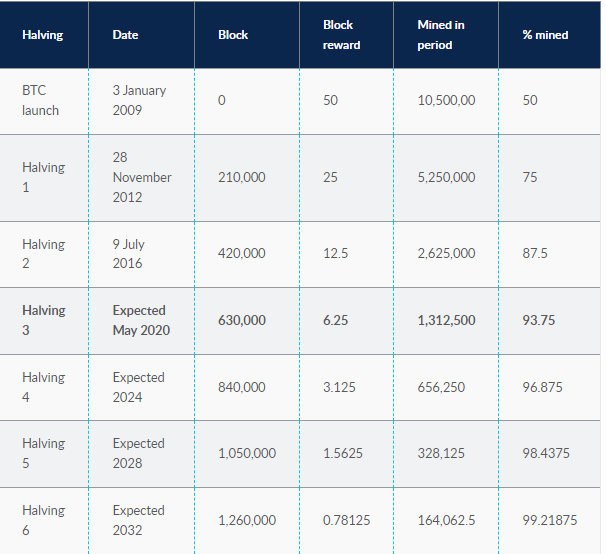


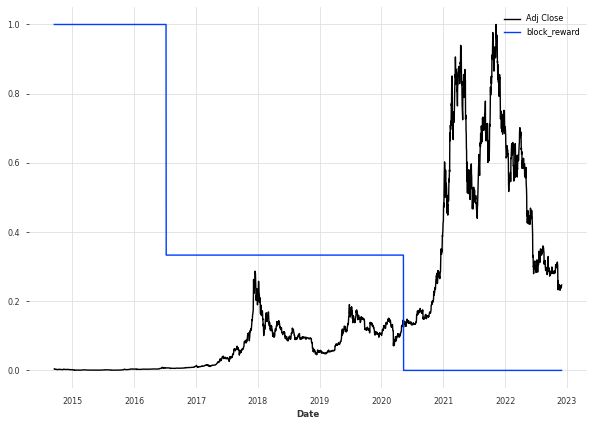

In [240]:
# Block reward values
block_reward_1 = 50 # 3 January 2009 - not in our set
block_reward_2 = 25 # 28 November 2012
block_reward_3 = 12.5 # 9 July 2016 
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

# Add block_reward column
multivariate = df[['Date', 'Adj Close']].copy()
multivariate["block_reward"] = None
multivariate.Date = multivariate.Date.apply(lambda x: x.date())
multivariate['block_reward']= np.where(multivariate['Date']> block_reward_4_datetime - 1,6.25, np.where(multivariate['Date'] < block_reward_3_datetime ,25,12.5))
multivariate.set_index('Date', inplace=True)

# Plot the block reward/price over time
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1.
scaled_price_block_df = pd.DataFrame(minmax_scale(multivariate[["Adj Close", "block_reward"]]), # we need to scale the data first
                                     columns=multivariate.columns,
                                     index=multivariate.index)
scaled_price_block_df.plot(figsize=(10, 7));

## Basic Plots

Volume Over Time

In [ ]:
df['Volume'].plot()

Price Distribution

In [ ]:
df_shortened = df[['Date','Open','High','Low','Close']]
df_shortened.Close.plot(kind = "hist", bins = 30)

Decomposition of the Data

In [ ]:
df_shortened.index = df_shortened['Date']
df_shortened['Closelog'] = np.log(df_shortened.Close)
decomposition = seasonal_decompose(df_shortened.Closelog)
decomposition.plot()

Monthly Average Prices with Heatmap

In [ ]:
plots= df[['Date', 'Adj Close']].copy()
plots.Date = plots.Date.apply(lambda x: x.date())

plots['month'] = pd.DatetimeIndex(plots['Date']).month
plots['year'] = pd.DatetimeIndex(plots['Date']).year
plots['day'] = pd.DatetimeIndex(plots['Date']).day
plots['weekday'] = pd.DatetimeIndex(plots['Date']).weekday
plots['week'] = pd.DatetimeIndex(plots['Date']).week
#plots.head()

all_month_year_df = pd.pivot_table(plots, values="Adj Close", index=["month"], columns=["year"], fill_value=0, margins=True)
named_index = [[calendar.month_abbr[i] if isinstance(i, int) else i for i in list(all_month_year_df.index)]] # name months
all_month_year_df = all_month_year_df.set_index(named_index)
#all_month_year_df.head()

ax = sns.heatmap(all_month_year_df, cmap='RdYlGn_r', robust=True, fmt='.2f', annot=True, 
                 linewidths=.5, annot_kws={'size':7},  cbar_kws={'shrink':.8, 'label':'Price(USD)'})                       
    
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
plt.title('Average Price per Month', fontdict={'fontsize':18},    pad=14);

## Feature Engineering

### for Window Method

In [4]:
WINDOW_SIZE = 7
HORIZON = 1

In [5]:
data= df[['Date', 'Adj Close']].copy()
data.Date = data.Date.apply(lambda x: x.date())

data.set_index('Date', inplace=True)

In [10]:
bitcoin_prices_nbeats = data.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Adj Close+{i+1}"] = bitcoin_prices_nbeats["Adj Close"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().tail(2)

,Adj Close,Adj Close+1,Adj Close+2,Adj Close+3,Adj Close+4,Adj Close+5,Adj Close+6,Adj Close+7
Date,,,,,,,,
2022-11-29,16444.982422,16217.322266,16444.626953,16464.281250,16521.841797,16604.464844,16610.707031,16189.769531
2022-11-30,16815.273438,16444.982422,16217.322266,16444.626953,16464.281250,16521.841797,16604.464844,16610.707031


In [7]:
test_size  = 0.15
valid_size = 0.15


test_split_idxx  = int(df.shape[0] * (1-test_size)) -WINDOW_SIZE +1                ########################################################## HAD TO ADJUST THIS!!!
valid_split_idxx = int(df.shape[0] * (1-(valid_size+test_size))) -WINDOW_SIZE +1   ########################################################## HAD TO ADJUST THIS!!!

print(test_split_idxx,valid_split_idxx )
print(bitcoin_prices_nbeats.shape)

X = bitcoin_prices_nbeats.dropna().drop("Adj Close", axis=1)
y = bitcoin_prices_nbeats.dropna()["Adj Close"]
print(len(X), len(y))
'''
train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()
'''
X_train, y_train = X[:valid_split_idxx], y[:valid_split_idxx]
X_test, y_test = X[valid_split_idxx:test_split_idxx], y[valid_split_idxx:test_split_idxx]
X_valid, y_valid = X[test_split_idxx:], y[test_split_idxx:]

print(len(y_train)+len(y_test)+len(y_valid)) # should be 7 lesss than len(X) GOOD
len(X_train), len(y_train), len(X_test), len(y_test), len(X_valid), len(y_valid)

2541 2091
(2997, 8)
2990 2990
2990


(2091, 2091, 450, 450, 449, 449)

## Plotting for Modeling

Test Splitting and Defining Horizon

In [11]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()


In [12]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Close, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.Close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.Close,  name='Test'))
fig.show()

##FFNN

In [13]:
#Construction of FFNN
model = Sequential()
model.add(Dense(64, input_dim=WINDOW_SIZE, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['acc'])
#print(model.summary())

In [ ]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), verbose=2, epochs=25)

In [31]:
test_predict = model.predict(X_valid)
test_predict = [item for sublist in test_predict for item in sublist]
result= pd.DataFrame(zip(test_predict, test_df['Adj Close']), columns =['Predicted', 'Actual'])

model__results = evaluate_preds(y_true=test_df['Adj Close'],  y_pred=test_predict)
model__results


15/15 [==============================] - 0s 2ms/step


{'mae': 894.82477, 'mse': 1714732.8, 'rmse': 1309.478, 'mape': 2.5032852}

<AxesSubplot:>

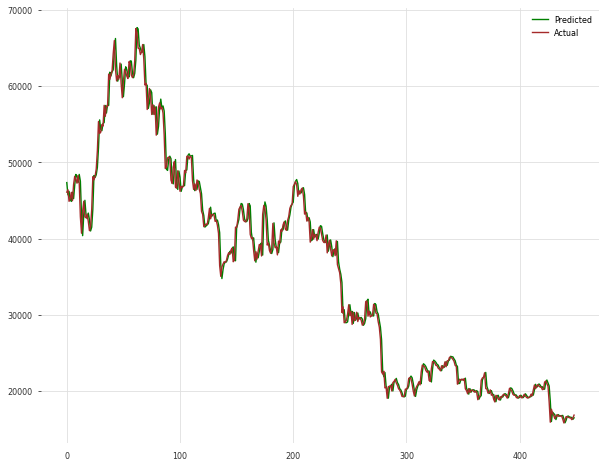

In [32]:
result[['Predicted', 'Actual']].plot(color=['green', 'brown'])

In [34]:
result.head()

,Predicted,Actual
0,47342.535156,46091.390625
1,45736.570312,46391.421875
2,46193.808594,44883.910156
3,45098.285156,45201.457031
4,44873.046875,46063.269531


##N-BEATS
Neural Basis Expansion Analyis for Interpretable Time Series
- **https://towardsdatascience.com/the-easiest-way-to-forecast-time-series-using-n-beats-d778fcc2ba60**
- https://source.sheridancollege.ca/cgi/viewcontent.cgi?article=1008&context=fast_sw_mobile_computing_theses
- https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/10_time_series_forecasting_in_tensorflow.ipynb
- https://www.kaggle.com/code/gatandubuc/forecast-with-n-beats-interpretable-model/notebook
- https://www.kaggle.com/code/rinichristy/interpretable-nbeats-to-predict-store-sales
- https://www.advancinganalytics.co.uk/blog/2021/06/22/10-incredibly-useful-time-series-forecasting-algorithms

- **https://unit8co.github.io/darts/examples/07-NBEATS-examples.html**

- **https://kerasbeats.readthedocs.io/en/latest/#**

#### Tuning (Does not work)

In [ ]:
def model_builder(hp):
    
    hp_n_neurons_trend = hp.Int('neurons_trend', min_value = 4, max_value=16, step=2)
    hp_n_neurons_seas = hp.Int('neurons_seas', min_value = 4, max_value=16, step=2)
    hp_periods = hp.Int('periods', min_value = 1, max_value = horizon, step = 30)
    hp_back_periods = hp.Int('back_periods', min_value = 1, max_value = back_horizon, step = 30)
    #hp_share = hp.Boolean('share')
    
    model_nbeats = create_interpretable_nbeats(#horizon=horizon, 
                                               #back_horizon=back_horizon,
                                               p_degree=1,   
                                               trend_n_neurons=hp_n_neurons_trend, 
                                               seasonality_n_neurons=hp_n_neurons_seas, 
                                               #periods=hp_periods, 
                                               #back_periods=hp_back_periods, 
                                               #horizon_fourier_order=hp_periods,
                                               #back_horizon_fourier_order=hp_back_periods,
                                               #n_quantiles=3,
                                               label_width=w_oneshot.label_width)
    #, share=hp_share)

    model_nbeats.compile(loss=QuantileLossError([0.1, 0.5, 0.9]), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                         metrics=[tf.keras.metrics.MeanAbsoluteError()])

    return model_nbeats

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_mean_absolute_error', 
                     max_epochs = 10)

In [ ]:
tuner = BayesianOptimization( model_builder, objective=kt.Objective("val_auc", direction="max"), 
                             max_trials=4, overwrite= True)

In [ ]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

In [ ]:
tuner.search(train_df, dataset.y_train, epochs = 10, 
             validation_data = (dataset.X_val, dataset.y_val), callbacks = [ClearTrainingOutput()])

In [ ]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,Symbol
0,2020-06-30 00:00:00+00:00,9185.581055,9217.835938,9084.837891,9137.993164,9137.993164,15735797744,BTC-USD
1,2020-07-01 00:00:00+00:00,9145.985352,9309.754883,9104.735352,9228.325195,9228.325195,15971550355,BTC-USD
2,2020-07-02 00:00:00+00:00,9231.139648,9274.962891,9036.623047,9123.410156,9123.410156,16338916796,BTC-USD
3,2020-07-03 00:00:00+00:00,9124.842773,9202.344727,9058.794922,9087.303711,9087.303711,13078970999,BTC-USD
4,2020-07-04 00:00:00+00:00,9084.233398,9183.295898,9053.629883,9132.488281,9132.488281,12290528515,BTC-USD
...,...,...,...,...,...,...,...,...
850,2022-10-28 00:00:00+00:00,20287.957031,20724.980469,20086.068359,20595.351562,20595.351562,43994715910,BTC-USD
851,2022-10-29 00:00:00+00:00,20595.103516,20988.394531,20566.484375,20818.476562,20818.476562,40369840645,BTC-USD
852,2022-10-30 00:00:00+00:00,20817.982422,20917.005859,20547.462891,20635.603516,20635.603516,31486345556,BTC-USD
853,2022-10-31 00:00:00+00:00,20633.695312,20795.320312,20287.458984,20495.773438,20495.773438,45668466815,BTC-USD


## This N-BEATS WORKS
needs to be tuned

In [35]:
# Create NBeatsBlock custom layer 
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called 
    x = inputs 
    for layer in self.hidden: # pass inputs through each hidden layer 
      x = layer(x)
    theta = self.theta_layer(x) 
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [36]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE, 
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast 
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [37]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [38]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [-0.8443885   0.4530268  -0.24615562 -0.09771675  0.44938678  0.21554121
  1.1983858 ]
Forecast: -1.8625239133834839


In [39]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

valid_features_dataset= tf.data.Dataset.from_tensor_slices(X_valid)
valid_labels_dataset = tf.data.Dataset.from_tensor_slices(y_valid)


# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))
valid_dataset = tf.data.Dataset.zip((valid_features_dataset, valid_labels_dataset))


# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

valid_dataset = valid_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset, valid_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [40]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 10 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

In [41]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


In [48]:
%%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174 
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=['acc'])


CPU times: user 2.45 s, sys: 42.3 ms, total: 2.49 s
Wall time: 2.36 s


In [49]:
# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

#model_7.evaluate(test_dataset)

In [44]:
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 2s 2s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8838.698, 8791.219, 8852.601, 8757.07 , 8809.141, 8792.259,
       8696.019, 8668.391, 8661.774, 8764.065], dtype=float32)>

In [52]:
# Evaluate N-BEATS model predictions
test_predict =  model_7.predict(valid_dataset)
test_predict = [item for sublist in test_predict for item in sublist]
result= pd.DataFrame(zip(test_predict, test_df['Adj Close']), columns =['Predicted', 'Actual'])

model__results = evaluate_preds(y_true=test_df['Adj Close'],  y_pred=test_predict)
model__results

1/1 [==============================] - 1s 788ms/step


{'mae': 2538.8794, 'mse': 10368683.0, 'rmse': 3220.044, 'mape': 7.0909963}

<AxesSubplot:>

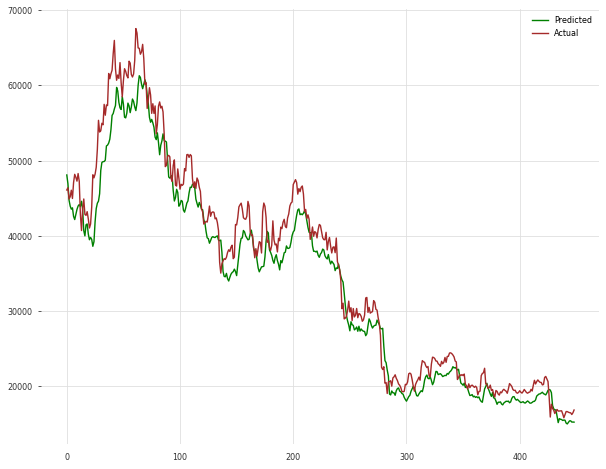

In [55]:
result[['Predicted', 'Actual']].plot( color=['green', 'brown'])

In [ ]:
#plot_model(model_7)
#model_7.save('my_model')
#new_model = tf.keras.models.load_model('my_model')

### NEW DARTS (other way to do it)

In [243]:
dataa = df[['Date', 'Adj Close']].copy()
dataa.Date = dataa.Date.apply(lambda x: x.date())

test_split_idx  = int(dataa.shape[0] * (1-valid_size))
valid_split_idx = int(dataa.shape[0] * (1-(valid_size)))

train_df  = dataa.loc[:valid_split_idx].copy()
test_df   = dataa.loc[test_split_idx+1:].copy()
#dataa.head()

In [244]:
max_L = max(train_df['Date'])
min_t = min(train_df['Date'])
horizon2 = (max_L-min_t).days 


max_valL = max(test_df['Date'])
min_valt = min(test_df['Date'])
horizon_val = (max_valL-min_valt).days 

train_df['Date'] = train_df['Date'].astype(str)
test_df['Date'] = test_df['Date'].astype(str)

DATE = str(min(valid_df["Date"]).year) + "0"+ str(min(valid_df["Date"]).month) + str(min(valid_df["Date"]).day) ## HAD TO ADD A ZERO BC we needed 06
#DATE

In [ ]:
## GOT RID OF THE SCALER
# scaler = Scaler()
#series = scaler.fit_transform(
#  filler.transform(TimeSeries.from_dataframe(dataa, "Date", "Adj Close"))).astype(np.float32)

filler = MissingValuesFiller()

series = filler.transform(TimeSeries.from_dataframe(train_df, "Date", "Adj Close")).astype(np.float32)
series_val = filler.transform(TimeSeries.from_dataframe(test_df, "Date", "Adj Close")).astype(np.float32)

series.plot()

In [247]:
train, val = series.split_after(pd.Timestamp(DATE))

val.head()

<TimeSeries (DataArray) (Date: 5, component: 1, sample: 1)>
array([[[9538.024]],

       [[9480.255]],

       [[9411.841]],

       [[9288.019]],

       [[9332.341]]], dtype=float32)
Coordinates:
  * Date       (Date) datetime64[ns] 2020-06-16 2020-06-17 ... 2020-06-20
  * component  (component) object 'Adj Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

Building the Model and training it

In [58]:
model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=10,
    nr_epochs_val_period=1,
    batch_size=800,
    model_name="nbeats_run",)

In [59]:
model_nbeats.fit(train, val_series=val, verbose=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.1 M 
---------------------------------------------------
8.1 M     Trainable params
2.7 K     Non-trainable params
8.1 M     Total params
32.368    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


  0%|          | 0/89 [00:00<?, ?it/s]

Predicting: 3it [00:00, ?it/s]

  1%|          | 1/89 [00:00<00:11,  7.55it/s]

Predicting: 3it [00:00, ?it/s]

  2%|▏         | 2/89 [00:00<00:11,  7.27it/s]

Predicting: 3it [00:00, ?it/s]

  3%|▎         | 3/89 [00:00<00:12,  7.10it/s]

Predicting: 3it [00:00, ?it/s]

  4%|▍         | 4/89 [00:00<00:11,  7.39it/s]

Predicting: 3it [00:00, ?it/s]

  6%|▌         | 5/89 [00:00<00:11,  7.49it/s]

Predicting: 3it [00:00, ?it/s]

  7%|▋         | 6/89 [00:00<00:10,  7.57it/s]

Predicting: 3it [00:00, ?it/s]

  8%|▊         | 7/89 [00:00<00:10,  7.66it/s]

Predicting: 3it [00:00, ?it/s]

  9%|▉         | 8/89 [00:01<00:10,  7.48it/s]

Predicting: 3it [00:00, ?it/s]

 10%|█         | 9/89 [00:01<00:10,  7.55it/s]

Predicting: 3it [00:00, ?it/s]

 11%|█         | 10/89 [00:01<00:10,  7.45it/s]

Predicting: 3it [00:00, ?it/s]

 12%|█▏        | 11/89 [00:01<00:10,  7.70it/s]

Predicting: 3it [00:00, ?it/s]

 13%|█▎        | 12/89 [00:01<00:10,  7.14it/s]

Predicting: 3it [00:00, ?it/s]

 15%|█▍        | 13/89 [00:01<00:10,  6.99it/s]

Predicting: 3it [00:00, ?it/s]

 16%|█▌        | 14/89 [00:01<00:11,  6.63it/s]

Predicting: 3it [00:00, ?it/s]

 17%|█▋        | 15/89 [00:02<00:11,  6.70it/s]

Predicting: 3it [00:00, ?it/s]

 18%|█▊        | 16/89 [00:02<00:10,  6.77it/s]

Predicting: 3it [00:00, ?it/s]

 19%|█▉        | 17/89 [00:02<00:10,  6.72it/s]

Predicting: 3it [00:00, ?it/s]

 20%|██        | 18/89 [00:02<00:10,  6.66it/s]

Predicting: 3it [00:00, ?it/s]

 21%|██▏       | 19/89 [00:02<00:11,  6.35it/s]

Predicting: 3it [00:00, ?it/s]

 22%|██▏       | 20/89 [00:02<00:11,  6.11it/s]

Predicting: 3it [00:00, ?it/s]

 24%|██▎       | 21/89 [00:03<00:11,  6.14it/s]

Predicting: 3it [00:00, ?it/s]

 25%|██▍       | 22/89 [00:03<00:10,  6.17it/s]

Predicting: 3it [00:00, ?it/s]

 26%|██▌       | 23/89 [00:03<00:10,  6.24it/s]

Predicting: 3it [00:00, ?it/s]

 27%|██▋       | 24/89 [00:03<00:10,  6.50it/s]

Predicting: 3it [00:00, ?it/s]

 28%|██▊       | 25/89 [00:03<00:09,  6.49it/s]

Predicting: 3it [00:00, ?it/s]

 29%|██▉       | 26/89 [00:03<00:09,  6.32it/s]

Predicting: 3it [00:00, ?it/s]

 30%|███       | 27/89 [00:03<00:09,  6.44it/s]

Predicting: 3it [00:00, ?it/s]

 31%|███▏      | 28/89 [00:04<00:09,  6.41it/s]

Predicting: 3it [00:00, ?it/s]

 33%|███▎      | 29/89 [00:04<00:09,  6.49it/s]

Predicting: 3it [00:00, ?it/s]

 34%|███▎      | 30/89 [00:04<00:08,  6.59it/s]

Predicting: 3it [00:00, ?it/s]

 35%|███▍      | 31/89 [00:04<00:08,  6.45it/s]

Predicting: 3it [00:00, ?it/s]

 36%|███▌      | 32/89 [00:04<00:09,  6.25it/s]

Predicting: 3it [00:00, ?it/s]

 37%|███▋      | 33/89 [00:04<00:08,  6.26it/s]

Predicting: 3it [00:00, ?it/s]

 38%|███▊      | 34/89 [00:05<00:08,  6.41it/s]

Predicting: 3it [00:00, ?it/s]

 39%|███▉      | 35/89 [00:05<00:08,  6.55it/s]

Predicting: 3it [00:00, ?it/s]

 40%|████      | 36/89 [00:05<00:07,  6.64it/s]

Predicting: 3it [00:00, ?it/s]

 42%|████▏     | 37/89 [00:05<00:07,  6.57it/s]

Predicting: 3it [00:00, ?it/s]

 43%|████▎     | 38/89 [00:05<00:07,  6.74it/s]

Predicting: 3it [00:00, ?it/s]

 44%|████▍     | 39/89 [00:05<00:07,  6.56it/s]

Predicting: 3it [00:00, ?it/s]

 45%|████▍     | 40/89 [00:05<00:07,  6.56it/s]

Predicting: 3it [00:00, ?it/s]

 46%|████▌     | 41/89 [00:06<00:07,  6.62it/s]

Predicting: 3it [00:00, ?it/s]

 47%|████▋     | 42/89 [00:06<00:07,  6.70it/s]

Predicting: 3it [00:00, ?it/s]

 48%|████▊     | 43/89 [00:06<00:06,  6.70it/s]

Predicting: 3it [00:00, ?it/s]

 49%|████▉     | 44/89 [00:06<00:06,  6.69it/s]

Predicting: 3it [00:00, ?it/s]

 51%|█████     | 45/89 [00:06<00:06,  6.74it/s]

Predicting: 3it [00:00, ?it/s]

 52%|█████▏    | 46/89 [00:06<00:06,  6.59it/s]

Predicting: 3it [00:00, ?it/s]

 53%|█████▎    | 47/89 [00:07<00:06,  6.57it/s]

Predicting: 3it [00:00, ?it/s]

 54%|█████▍    | 48/89 [00:07<00:06,  6.60it/s]

Predicting: 3it [00:00, ?it/s]

 55%|█████▌    | 49/89 [00:07<00:06,  6.51it/s]

Predicting: 3it [00:00, ?it/s]

 56%|█████▌    | 50/89 [00:07<00:05,  6.54it/s]

Predicting: 3it [00:00, ?it/s]

 57%|█████▋    | 51/89 [00:07<00:06,  6.14it/s]

Predicting: 3it [00:00, ?it/s]

 58%|█████▊    | 52/89 [00:07<00:06,  6.12it/s]

Predicting: 3it [00:00, ?it/s]

 60%|█████▉    | 53/89 [00:07<00:05,  6.19it/s]

Predicting: 3it [00:00, ?it/s]

 61%|██████    | 54/89 [00:08<00:05,  6.40it/s]

Predicting: 3it [00:00, ?it/s]

 62%|██████▏   | 55/89 [00:08<00:05,  6.60it/s]

Predicting: 3it [00:00, ?it/s]

 63%|██████▎   | 56/89 [00:08<00:05,  6.56it/s]

Predicting: 3it [00:00, ?it/s]

 64%|██████▍   | 57/89 [00:08<00:04,  6.57it/s]

Predicting: 3it [00:00, ?it/s]

 65%|██████▌   | 58/89 [00:08<00:04,  6.70it/s]

Predicting: 3it [00:00, ?it/s]

 66%|██████▋   | 59/89 [00:08<00:04,  6.75it/s]

Predicting: 3it [00:00, ?it/s]

 67%|██████▋   | 60/89 [00:09<00:04,  6.54it/s]

Predicting: 3it [00:00, ?it/s]

 69%|██████▊   | 61/89 [00:09<00:04,  6.66it/s]

Predicting: 3it [00:00, ?it/s]

 70%|██████▉   | 62/89 [00:09<00:03,  6.76it/s]

Predicting: 3it [00:00, ?it/s]

 71%|███████   | 63/89 [00:09<00:03,  6.62it/s]

Predicting: 3it [00:00, ?it/s]

 72%|███████▏  | 64/89 [00:09<00:03,  6.63it/s]

Predicting: 3it [00:00, ?it/s]

 73%|███████▎  | 65/89 [00:09<00:03,  6.56it/s]

Predicting: 3it [00:00, ?it/s]

 74%|███████▍  | 66/89 [00:09<00:03,  6.51it/s]

Predicting: 3it [00:00, ?it/s]

 75%|███████▌  | 67/89 [00:10<00:03,  6.36it/s]

Predicting: 3it [00:00, ?it/s]

 76%|███████▋  | 68/89 [00:11<00:08,  2.46it/s]

Predicting: 3it [00:00, ?it/s]

 78%|███████▊  | 69/89 [00:11<00:06,  3.02it/s]

Predicting: 3it [00:00, ?it/s]

 79%|███████▊  | 70/89 [00:11<00:05,  3.65it/s]

Predicting: 3it [00:00, ?it/s]

 80%|███████▉  | 71/89 [00:11<00:04,  4.20it/s]

Predicting: 3it [00:00, ?it/s]

 81%|████████  | 72/89 [00:11<00:03,  4.73it/s]

Predicting: 3it [00:00, ?it/s]

 82%|████████▏ | 73/89 [00:12<00:03,  4.07it/s]

Predicting: 3it [00:00, ?it/s]

 83%|████████▎ | 74/89 [00:12<00:06,  2.32it/s]

Predicting: 3it [00:00, ?it/s]

 84%|████████▍ | 75/89 [00:13<00:08,  1.70it/s]

Predicting: 3it [00:00, ?it/s]

 85%|████████▌ | 76/89 [00:14<00:07,  1.76it/s]

Predicting: 3it [00:00, ?it/s]

 87%|████████▋ | 77/89 [00:14<00:05,  2.22it/s]

Predicting: 3it [00:00, ?it/s]

 88%|████████▊ | 78/89 [00:14<00:04,  2.74it/s]

Predicting: 3it [00:00, ?it/s]

 89%|████████▉ | 79/89 [00:14<00:02,  3.34it/s]

Predicting: 3it [00:00, ?it/s]

 90%|████████▉ | 80/89 [00:14<00:02,  3.96it/s]

Predicting: 3it [00:00, ?it/s]

 91%|█████████ | 81/89 [00:15<00:01,  4.51it/s]

Predicting: 3it [00:00, ?it/s]

 92%|█████████▏| 82/89 [00:15<00:01,  5.01it/s]

Predicting: 3it [00:00, ?it/s]

 93%|█████████▎| 83/89 [00:15<00:01,  5.43it/s]

Predicting: 3it [00:00, ?it/s]

 94%|█████████▍| 84/89 [00:15<00:00,  5.78it/s]

Predicting: 3it [00:00, ?it/s]

 96%|█████████▌| 85/89 [00:15<00:00,  6.13it/s]

Predicting: 3it [00:00, ?it/s]

 97%|█████████▋| 86/89 [00:15<00:00,  6.27it/s]

Predicting: 3it [00:00, ?it/s]

 98%|█████████▊| 87/89 [00:16<00:00,  6.53it/s]

Predicting: 3it [00:00, ?it/s]

 99%|█████████▉| 88/89 [00:16<00:00,  6.63it/s]

Predicting: 3it [00:00, ?it/s]

100%|██████████| 89/89 [00:16<00:00,  5.46it/s]


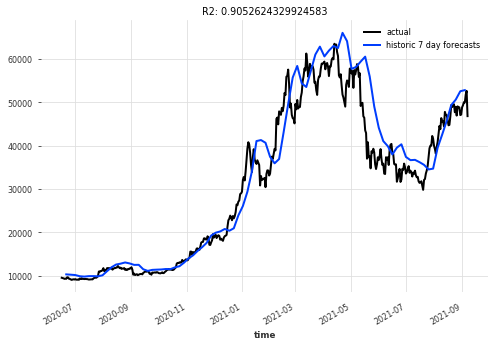

In [60]:
pred_series = model_nbeats.historical_forecasts(
    series,
    start=pd.Timestamp(DATE),
    forecast_horizon=7,
    stride=5,
    retrain=False,
    verbose=True,)

display_forecast(pred_series, series, "7 day", start_date=pd.Timestamp(DATE))

Predicting on unseen data

In [104]:
VALUES = model_nbeats.predict(n=horizon_val+1, series=series_val) ## have to fix it horizon will be the lenght of the test and should be on the test

Predicting: 3it [00:00, ?it/s]

In [131]:
print("predicted", model_nbeats.predict(n=1, series=series.tail(30))['Adj Close'].pd_dataframe())
print("actual",series_val[0].pd_dataframe())

Predicting: 3it [00:00, ?it/s]

predicted component      Adj Close
Date                    
2021-09-08  53034.722656
actual component      Adj Close
Date                    
2021-09-08  46091.390625


In [140]:
df = VALUES.pd_dataframe()
df.index = np.arange(0, len(VALUES.pd_dataframe()))
df.columns = df.columns.str.replace('Adj Close', 'Predicted_N-Beats')

actual = series_val.pd_dataframe()
actual.index = np.arange(0, len(actual))



result = pd.concat([df, actual] , ignore_index=True, axis = 1)
result.columns = ['Predicted_N-Beats', 'actual']

result

,Predicted_N-Beats,actual
0,17132.232422,46091.390625
1,15328.726562,46391.421875
2,17237.777344,44883.910156
3,15426.471680,45201.457031
4,16582.724609,46063.269531
...,...,...
444,184426.234375,16464.281250
445,166907.734375,16444.626953
446,178050.093750,16217.322266
447,183127.531250,16444.982422


<AxesSubplot: >

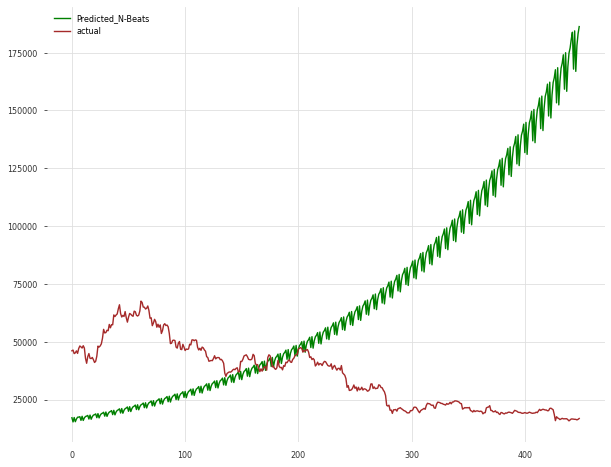

In [141]:
result[['Predicted_N-Beats', 'actual']].plot( color=['green', 'brown'])


The other setup for N-BEATS (non-generic one)
includes trend stack and seaonality stack

In [142]:
model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    generic_architecture=False,
    num_blocks=3,
    num_layers=4,
    layer_widths=512,
    n_epochs=10,
    nr_epochs_val_period=1,
    batch_size=800,
    model_name="nbeats_interpretable_run",
)

In [143]:
model_nbeats.fit(series=train, val_series=val, verbose=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 1.6 M 
---------------------------------------------------
1.6 M     Trainable params
15.9 K    Non-trainable params
1.6 M     Total params
6.517     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


  0%|          | 0/89 [00:00<?, ?it/s]

Predicting: 3it [00:00, ?it/s]

  1%|          | 1/89 [00:00<00:14,  6.10it/s]

Predicting: 3it [00:00, ?it/s]

  2%|▏         | 2/89 [00:00<00:14,  5.95it/s]

Predicting: 3it [00:00, ?it/s]

  3%|▎         | 3/89 [00:00<00:14,  5.82it/s]

Predicting: 3it [00:00, ?it/s]

  4%|▍         | 4/89 [00:00<00:15,  5.66it/s]

Predicting: 3it [00:00, ?it/s]

  6%|▌         | 5/89 [00:00<00:14,  5.62it/s]

Predicting: 3it [00:00, ?it/s]

  7%|▋         | 6/89 [00:01<00:14,  5.69it/s]

Predicting: 3it [00:00, ?it/s]

  8%|▊         | 7/89 [00:01<00:14,  5.64it/s]

Predicting: 3it [00:00, ?it/s]

  9%|▉         | 8/89 [00:01<00:13,  6.17it/s]

Predicting: 3it [00:00, ?it/s]

 10%|█         | 9/89 [00:01<00:13,  5.84it/s]

Predicting: 3it [00:00, ?it/s]

 11%|█         | 10/89 [00:01<00:12,  6.13it/s]

Predicting: 3it [00:00, ?it/s]

 12%|█▏        | 11/89 [00:01<00:11,  6.69it/s]

Predicting: 3it [00:00, ?it/s]

 13%|█▎        | 12/89 [00:01<00:10,  7.35it/s]

Predicting: 3it [00:00, ?it/s]

 15%|█▍        | 13/89 [00:02<00:09,  7.76it/s]

Predicting: 3it [00:00, ?it/s]

 16%|█▌        | 14/89 [00:02<00:09,  8.13it/s]

Predicting: 3it [00:00, ?it/s]

 17%|█▋        | 15/89 [00:02<00:08,  8.51it/s]

Predicting: 3it [00:00, ?it/s]

 18%|█▊        | 16/89 [00:02<00:08,  8.48it/s]

Predicting: 3it [00:00, ?it/s]

 19%|█▉        | 17/89 [00:02<00:08,  8.64it/s]

Predicting: 3it [00:00, ?it/s]

 20%|██        | 18/89 [00:02<00:08,  8.36it/s]

Predicting: 3it [00:00, ?it/s]

 21%|██▏       | 19/89 [00:02<00:08,  8.54it/s]

Predicting: 3it [00:00, ?it/s]

 22%|██▏       | 20/89 [00:02<00:07,  8.74it/s]

Predicting: 3it [00:00, ?it/s]

 24%|██▎       | 21/89 [00:02<00:07,  8.65it/s]

Predicting: 3it [00:00, ?it/s]

 25%|██▍       | 22/89 [00:03<00:07,  8.73it/s]

Predicting: 3it [00:00, ?it/s]

 26%|██▌       | 23/89 [00:03<00:07,  8.74it/s]

Predicting: 3it [00:00, ?it/s]

 27%|██▋       | 24/89 [00:03<00:07,  8.82it/s]

Predicting: 3it [00:00, ?it/s]

 28%|██▊       | 25/89 [00:03<00:07,  8.93it/s]

Predicting: 3it [00:00, ?it/s]

 29%|██▉       | 26/89 [00:03<00:07,  8.90it/s]

Predicting: 3it [00:00, ?it/s]

 30%|███       | 27/89 [00:03<00:07,  8.41it/s]

Predicting: 3it [00:00, ?it/s]

 31%|███▏      | 28/89 [00:03<00:07,  8.05it/s]

Predicting: 3it [00:00, ?it/s]

 33%|███▎      | 29/89 [00:03<00:07,  7.88it/s]

Predicting: 3it [00:00, ?it/s]

 34%|███▎      | 30/89 [00:04<00:07,  7.80it/s]

Predicting: 3it [00:00, ?it/s]

 35%|███▍      | 31/89 [00:04<00:07,  7.84it/s]

Predicting: 3it [00:00, ?it/s]

 36%|███▌      | 32/89 [00:04<00:07,  7.91it/s]

Predicting: 3it [00:00, ?it/s]

 37%|███▋      | 33/89 [00:04<00:07,  7.82it/s]

Predicting: 3it [00:00, ?it/s]

 38%|███▊      | 34/89 [00:04<00:07,  7.75it/s]

Predicting: 3it [00:00, ?it/s]

 39%|███▉      | 35/89 [00:04<00:06,  7.88it/s]

Predicting: 3it [00:00, ?it/s]

 40%|████      | 36/89 [00:04<00:06,  7.94it/s]

Predicting: 3it [00:00, ?it/s]

 42%|████▏     | 37/89 [00:04<00:06,  7.88it/s]

Predicting: 3it [00:00, ?it/s]

 43%|████▎     | 38/89 [00:05<00:06,  7.72it/s]

Predicting: 3it [00:00, ?it/s]

 44%|████▍     | 39/89 [00:05<00:06,  7.40it/s]

Predicting: 3it [00:00, ?it/s]

 45%|████▍     | 40/89 [00:05<00:07,  6.97it/s]

Predicting: 3it [00:00, ?it/s]

 46%|████▌     | 41/89 [00:05<00:06,  7.10it/s]

Predicting: 3it [00:00, ?it/s]

 47%|████▋     | 42/89 [00:05<00:06,  7.28it/s]

Predicting: 3it [00:00, ?it/s]

 48%|████▊     | 43/89 [00:05<00:06,  7.13it/s]

Predicting: 3it [00:00, ?it/s]

 49%|████▉     | 44/89 [00:05<00:06,  7.38it/s]

Predicting: 3it [00:00, ?it/s]

 51%|█████     | 45/89 [00:06<00:05,  7.42it/s]

Predicting: 3it [00:00, ?it/s]

 52%|█████▏    | 46/89 [00:06<00:05,  7.45it/s]

Predicting: 3it [00:00, ?it/s]

 53%|█████▎    | 47/89 [00:06<00:05,  7.34it/s]

Predicting: 3it [00:00, ?it/s]

 54%|█████▍    | 48/89 [00:06<00:05,  7.53it/s]

Predicting: 3it [00:00, ?it/s]

 55%|█████▌    | 49/89 [00:06<00:05,  7.43it/s]

Predicting: 3it [00:00, ?it/s]

 56%|█████▌    | 50/89 [00:06<00:05,  7.51it/s]

Predicting: 3it [00:00, ?it/s]

 57%|█████▋    | 51/89 [00:06<00:05,  7.45it/s]

Predicting: 3it [00:00, ?it/s]

 58%|█████▊    | 52/89 [00:06<00:05,  7.33it/s]

Predicting: 3it [00:00, ?it/s]

 60%|█████▉    | 53/89 [00:07<00:05,  6.85it/s]

Predicting: 3it [00:00, ?it/s]

 61%|██████    | 54/89 [00:07<00:05,  6.74it/s]

Predicting: 3it [00:00, ?it/s]

 62%|██████▏   | 55/89 [00:07<00:05,  6.23it/s]

Predicting: 3it [00:00, ?it/s]

 63%|██████▎   | 56/89 [00:07<00:05,  6.21it/s]

Predicting: 3it [00:00, ?it/s]

 64%|██████▍   | 57/89 [00:07<00:04,  6.41it/s]

Predicting: 3it [00:00, ?it/s]

 65%|██████▌   | 58/89 [00:07<00:04,  6.31it/s]

Predicting: 3it [00:00, ?it/s]

 66%|██████▋   | 59/89 [00:08<00:04,  6.39it/s]

Predicting: 3it [00:00, ?it/s]

 67%|██████▋   | 60/89 [00:08<00:04,  6.71it/s]

Predicting: 3it [00:00, ?it/s]

 69%|██████▊   | 61/89 [00:08<00:03,  7.23it/s]

Predicting: 3it [00:00, ?it/s]

 70%|██████▉   | 62/89 [00:08<00:03,  7.66it/s]

Predicting: 3it [00:00, ?it/s]

 71%|███████   | 63/89 [00:08<00:03,  7.90it/s]

Predicting: 3it [00:00, ?it/s]

 72%|███████▏  | 64/89 [00:08<00:03,  8.32it/s]

Predicting: 3it [00:00, ?it/s]

 73%|███████▎  | 65/89 [00:08<00:02,  8.39it/s]

Predicting: 3it [00:00, ?it/s]

 74%|███████▍  | 66/89 [00:08<00:02,  8.10it/s]

Predicting: 3it [00:00, ?it/s]

 75%|███████▌  | 67/89 [00:09<00:02,  7.72it/s]

Predicting: 3it [00:00, ?it/s]

 76%|███████▋  | 68/89 [00:09<00:02,  7.67it/s]

Predicting: 3it [00:00, ?it/s]

 78%|███████▊  | 69/89 [00:09<00:02,  7.37it/s]

Predicting: 3it [00:00, ?it/s]

 79%|███████▊  | 70/89 [00:09<00:02,  7.31it/s]

Predicting: 3it [00:00, ?it/s]

 80%|███████▉  | 71/89 [00:09<00:02,  7.23it/s]

Predicting: 3it [00:00, ?it/s]

 81%|████████  | 72/89 [00:09<00:02,  7.62it/s]

Predicting: 3it [00:00, ?it/s]

 82%|████████▏ | 73/89 [00:09<00:02,  7.68it/s]

Predicting: 3it [00:00, ?it/s]

 83%|████████▎ | 74/89 [00:10<00:02,  7.28it/s]

Predicting: 3it [00:00, ?it/s]

 84%|████████▍ | 75/89 [00:10<00:01,  7.41it/s]

Predicting: 3it [00:00, ?it/s]

 85%|████████▌ | 76/89 [00:10<00:01,  7.46it/s]

Predicting: 3it [00:00, ?it/s]

 87%|████████▋ | 77/89 [00:10<00:01,  7.66it/s]

Predicting: 3it [00:00, ?it/s]

 88%|████████▊ | 78/89 [00:10<00:01,  7.70it/s]

Predicting: 3it [00:00, ?it/s]

 89%|████████▉ | 79/89 [00:10<00:01,  7.67it/s]

Predicting: 3it [00:00, ?it/s]

 90%|████████▉ | 80/89 [00:10<00:01,  7.83it/s]

Predicting: 3it [00:00, ?it/s]

 91%|█████████ | 81/89 [00:10<00:01,  7.85it/s]

Predicting: 3it [00:00, ?it/s]

 92%|█████████▏| 82/89 [00:11<00:00,  7.71it/s]

Predicting: 3it [00:00, ?it/s]

 93%|█████████▎| 83/89 [00:11<00:00,  7.53it/s]

Predicting: 3it [00:00, ?it/s]

 94%|█████████▍| 84/89 [00:11<00:00,  7.48it/s]

Predicting: 3it [00:00, ?it/s]

 96%|█████████▌| 85/89 [00:11<00:00,  7.48it/s]

Predicting: 3it [00:00, ?it/s]

 97%|█████████▋| 86/89 [00:11<00:00,  7.62it/s]

Predicting: 3it [00:00, ?it/s]

 98%|█████████▊| 87/89 [00:11<00:00,  7.22it/s]

Predicting: 3it [00:00, ?it/s]

 99%|█████████▉| 88/89 [00:11<00:00,  7.46it/s]

Predicting: 3it [00:00, ?it/s]

100%|██████████| 89/89 [00:12<00:00,  7.40it/s]


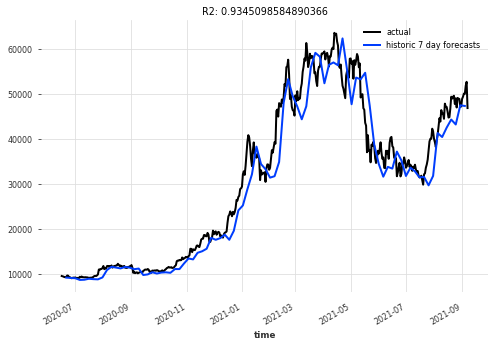

In [144]:
pred_series = model_nbeats.historical_forecasts(
    series,
    start=pd.Timestamp(DATE),
    forecast_horizon=7,
    stride=5,
    retrain=False,
    verbose=True,
)
display_forecast(pred_series, series, "7 day", start_date=pd.Timestamp(DATE))

In [145]:
VALUES = model_nbeats.predict(n=horizon_val+1, series=series_val) ## have to fix it horizon will be the lenght of the test and should be on the test

Predicting: 3it [00:00, ?it/s]

In [146]:
df = VALUES.pd_dataframe()
df.index = np.arange(0, len(VALUES.pd_dataframe()))
df.columns = df.columns.str.replace('Adj Close', 'Predicted_N-Beats')

actual = series_val.pd_dataframe()
actual.index = np.arange(0, len(actual))



result = pd.concat([df, actual] , ignore_index=True, axis = 1)
result.columns = ['Predicted_N-Beats', 'actual']

result

,Predicted_N-Beats,actual
0,16021.629883,46091.390625
1,15912.420898,46391.421875
2,15758.826172,44883.910156
3,15833.221680,45201.457031
4,15752.844727,46063.269531
...,...,...
444,282.174866,16464.281250
445,281.293671,16444.626953
446,278.529480,16217.322266
447,276.973145,16444.982422


<AxesSubplot: >

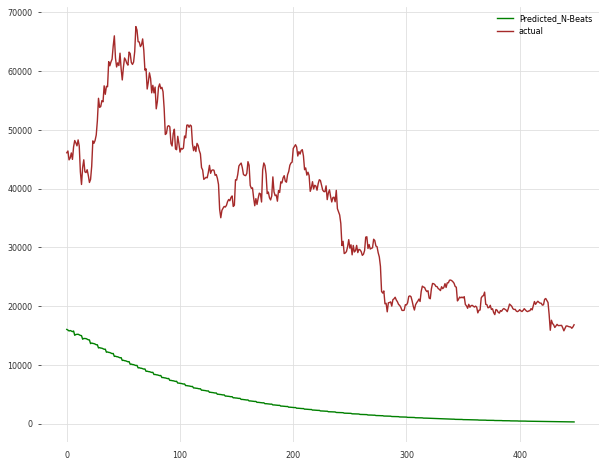

In [147]:
result[['Predicted_N-Beats', 'actual']].plot( color=['green', 'brown'])


### THIS HAS POTENTIAL

In [4]:
######from ts.training_prediction.model.assets import *
#########from ts.etl.training_prediction import *
###########from ts.etl.visualization import *

# ML/DS libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import tensorflow as tf
from tensorflow.keras import layers
import os
from datetime import datetime
from sklearn.preprocessing import minmax_scale
from tensorflow.keras.utils import plot_model

# AWS libraries
import boto3
# Data loading libraries
import yfinance as yf

In [56]:
WINDOW_SIZE_WEEK = 7
HORIZON_DAY = 1
import pandas as pd

# Global variables for window and horizon size
WINDOW_SIZE_WEEK = 7
WINDOW_SIZE_MONTH = 30
WINDOW_SIZE_2_MONTH = 60

HORIZON_DAY = 1
HORIZON_WEEK = 7
HORIZON_MONTH = 30

# Timesteps into the future
INTO_FUTURE_WEEK = 7
INTO_FUTURE_2_WEEK = 14
INTO_FUTURE_MONTH = 30
INTO_FUTURE_2_MONTH = 60

# Block reward values
BLOCK_REWARD_1 = 50 # After 3 January 2009 (2009-01-03) - this block reward isn't accounted for in BTC prices
BLOCK_REWARD_2 = 25 # After 28 November 2012
BLOCK_REWARD_3 = 12.5 # After 9 July 2016
BLOCK_REWARD_4 = 6.25 # After 11 May 2020

# Block reward dates (datetime form of the above date stamps for block rewards)
BLOCK_REWARD_1_DATETIME = pd.Timestamp('2009-01-03')
BLOCK_REWARD_2_DATETIME = pd.Timestamp('2012-11-28')
BLOCK_REWARD_3_DATETIME = pd.Timestamp('2016-07-09')
BLOCK_REWARD_4_DATETIME = pd.Timestamp('2020-05-11')

# Batch sizes
NBEATS_BATCH_SIZE = 1024
BATCH_SIZE = 1024

# N-BEATS hyperparameters
# Values from N-BEATS paper in Figure 1 and Table 18/Appendix D
NBEATS_N_EPOCHS = 10 ######################### CHANGED IT FROM 100
NBEATS_N_NEURONS = 512
NBEATS_N_LAYERS = 4
NBEATS_N_STACKS = 30

NBEATS_INPUT_SIZE = WINDOW_SIZE_WEEK * HORIZON_DAY # Lookback period in Appendix D
NBEATS_THETA_SIZE = NBEATS_INPUT_SIZE + HORIZON_DAY

# Ensemble models training hyperparameters
ENSEMBLE_NUM_ITER = 1
ENSEMBLE_NUM_EPOCHS = 1


def make_windows(x, window_size=WINDOW_SIZE_WEEK, horizon=HORIZON_DAY):
    """
    Turns a 1D array into a 2D array of sequential labelled windows of 
    window_size with horizon size labels.
    Returns both a 2D array containing full windowed X values with shape
    (number of samples, window size), and a 2D array containing full
    labelled y values with shape (number of samples, horizon size).
    """
    # TODO: In the future, function could be implemented using https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array

    # 1. Create a window of specific window_size (add the horizon on the end for labelling later)
    window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)

    # 2. Create a 2D of multiple window steps (minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis=0).T # Create 2D array of windows of window size
    # print(f"Window indexes: \n {window_indexes, window_indexes.shape}")

    windowed_array = x[window_indexes]
    # print(windowed_array)

    # 4. Get the labelled window
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

    return windows, labels


def get_labelled_windows(x, horizon=HORIZON_DAY):
    """
    Create labels for windowed dataset.
    E.g. if horizon is 1, then:
    x: [0, 1, 2, 3, 4, 5, 6, 7] -> output: ([0, 1, 2, 3, 4, 5, 6], [7])
    """
    return x[:, :-horizon], x[:, -horizon:]


# Implementation of train/test split after windowing is in effect
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into train and test splits.
    """
    split_size = int(len(windows) * (1 - test_split)) # This will default to 80% train and 20% test
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]

    print(train_windows.shape, test_windows.shape, train_labels.shape, test_labels.shape)

    return train_windows, test_windows, train_labels, test_labels


def get_ensemble_models(models, train_data, test_data, horizon=HORIZON_DAY, num_iter=1, num_epochs=10,
                        loss_funcs=["mae", "mse", "mape"]):
    """
    Returns a list of num_iter models each trained on MAE, MSE and MAPE loss 
    functions by default.
    For instance, if num_iter = 10, a list of 30 trained models will be returned.
    10 * len(loss_funcs) * 3 = 90
    """
    # Make empty list for trained ensemble models
    ensemble_models = []

    # Create num_iter number of models per loss function for NBeats, LSTM and Dense models
    for i in range(num_iter):
        # Build and fit ensemble of models
        for model in models:
            for loss_func in loss_funcs:
                print(f"Optimizing model by reducing: {loss_func} for epochs: {num_epochs}, num_iter: {i}, model: {model.name}")

                # Compile model with current loss function
                model.compile(loss=loss_func, optimizer=tf.keras.optimizers.Adam(), metrics=["mae", "mse"])

                # Fit the model
                model.fit(train_data, epochs=num_epochs, verbose=2, validation_data=test_data,
                          callbacks=[#create_model_checkpoint(model_name=f"{model.name}_{i}_{loss_func}"),
                                     tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                                     tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])
                
                # Append fitted model to list of ensemble models
                ensemble_models.append(model)
    
    return ensemble_models


def make_ensemble_preds(ensemble_models, input_data):
    """
    Returns predictions of ensemble models.
    Parameters
    ----------
    ensemble_models: Trained ensemble of models.
    input_data: Data to be predicted with.
    """
    ensemble_preds = []
    
    for model in ensemble_models:
        preds = model.predict(input_data) # Make predictions with current ensemble model
        ensemble_preds.append(preds)
    
    return tf.constant(tf.squeeze(ensemble_preds))

In [57]:
class NBEATSBlock(tf.keras.layers.Layer):
    def __init__(self, input_size: int, theta_size: int, horizon: int, n_neurons: int, n_layers: int, **kwargs):
        """
        Initializes NEATSBlock class using below parameters.
        Parameters
        ----------
        input_size: Size of backcast (window size).
        theta_size: Number of neurons in output dense layer, backcast + forecast.
        horizon: Size of horizon, forecast prediction.
        n_neurons: Number of neurons in fully connected dense layer.
        n_layers: Number of fully connected dense layers.
        kwargs: Passed to tf.keras.layers.Layers
        """
        super().__init__(**kwargs)
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layers = n_layers

        # One block contains a stack of 4 fully connected dense layers, each has a ReLU activation function
        self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for layer in range(n_layers)]

        # Output of block is a dense layer of theta_size with linear activation
        self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear")
    
    def __call__(self, inputs):
        """
        Runs when the layer is called.
        """
        x = inputs
        for layer in self.hidden: # pass inputs through each hidden layer
            x = layer(x)
        theta = self.theta_layer(x)

        # Output the backcast and forecast from theta
        backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]

        return backcast, forecast


def gen_train_test_datasets(X_train, y_train, X_test, y_test, batch_size=BATCH_SIZE):
    """
    Returns the train and test datasets using the tf.data API from train and
    test arrays.
    Parameters
    ----------
    X_train: Training windows.
    y_train: Training labels.
    X_test: Testing windows.
    y_test: Testing labels.
    batch_size: Batch size used for training.
    """
    # 1. Turn train and test arrays into tensor Datasets
    train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
    train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

    test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
    test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

    # 2. Combine features & labels
    train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
    test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

    # 3. Batch and prefetch for optimal performance
    train_dataset = train_dataset.batch(batch_size=batch_size).prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(batch_size=batch_size).prefetch(tf.data.AUTOTUNE)

    return train_dataset, test_dataset


def get_ensemble_models_summary(models):
    """
    Generates model summaries of ensemble models.
    Parameters
    ----------
    models: Ensemble of models.
    """
    for model in models:
        print(model.summary())

def make_ensemble_preds(ensemble_models, input_data):
    """
    Returns predictions of ensemble models.
    Parameters
    ----------
    ensemble_models: Trained ensemble of models.
    input_data: Data to be predicted with.
    """
    ensemble_preds = []
    
    for model in ensemble_models:
        preds = model.predict(input_data) # Make predictions with current ensemble model
        ensemble_preds.append(preds)
    
    return tf.constant(tf.squeeze(ensemble_preds))

In [58]:
def get_NBEATS_model(model_name="NBEATS_model"):
        """
        Returns a NBEATS model using the Functional API.
        Parameters
        ----------
        model_name: Model's name.        
        """
        # TODO: Adjust this function to take into consideration if more features are used for the model, if more features are
        # used, then the NBEATS_INPUT_SIZE + 1 will need to change.
        # 1. Setup NBEATSBlock layer
        nbeats_block_layer = NBEATSBlock(input_size=NBEATS_INPUT_SIZE , theta_size=NBEATS_THETA_SIZE, horizon=HORIZON_DAY,
                                         n_neurons=NBEATS_N_NEURONS, n_layers=NBEATS_N_LAYERS, name="initial_block")
        
        # 2. Create input to stacks
        stack_input = layers.Input(shape=(NBEATS_INPUT_SIZE ), name="stack_input")

        # 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
        backcast, forecast = nbeats_block_layer(stack_input)
        # Add in subtraction residual connections
        residuals = layers.subtract([stack_input, backcast], name=f"subtract_00")

        # 4. Create stacks of blocks
        for i, _ in enumerate(range(NBEATS_N_STACKS - 1)):
            # First stack is already created in # 3
            # 5. Use NBEATSBlock to calculate the backcast as well as block's forecast
            backcast, block_forecast = NBEATSBlock(
                input_size=NBEATS_INPUT_SIZE ,
                theta_size=NBEATS_THETA_SIZE,
                horizon=HORIZON_DAY,
                n_neurons=NBEATS_N_NEURONS,
                n_layers=NBEATS_N_LAYERS,
                name=f"NBEATSBlock_{i}"
            )(residuals) # Pass in the residuals (the backcast)

            # 6. Create the double residual stacking
            residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
            forecast = layers.add([forecast, block_forecast], name=f"add_{i}")
        
        # 7. Put the stack model together
        NBEATS_model = tf.keras.Model(inputs=stack_input, outputs=forecast, name=model_name)

        return NBEATS_model

In [59]:
url = 'https://raw.githubusercontent.com/bmarci99/Crypto_trading/main/Data/BTC-USD.csv' ##  CoinMarketCap prices


df = pd.read_csv(url)
df_btc_price_closing = df[['Date', 'Close']]
dataset_timesteps = df_btc_price_closing.index.to_numpy() ## I THINK I AM SUPPOSED TO HAVe THIS AS TIMES
dataset_prices = df_btc_price_closing['Close'].to_numpy()
dataset_prices
dataset_full_windows, dataset_full_labels = make_windows(dataset_prices, window_size=WINDOW_SIZE_WEEK, horizon=HORIZON_DAY)
#print(dataset_full_windows.shape, dataset_full_labels.shape)

#print(pd.DataFrame(dataset_prices))
#print(pd.DataFrame(dataset_full_windows))
#print(pd.DataFrame(dataset_full_labels))

# Testing out the train/test split function
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(dataset_full_windows, dataset_full_labels)
print(train_windows.shape, test_windows.shape, train_labels.shape, test_labels.shape)

# Obtain the train and test datasets
train_dataset, test_dataset = gen_train_test_datasets(X_train=train_windows, y_train=train_labels,
                                                      X_test=test_windows, y_test=test_labels)
print(f"Train dataset: {train_dataset}", f"Test dataset: {test_dataset}")

(2392, 7) (598, 7) (2392, 1) (598, 1)
(2392, 7) (598, 7) (2392, 1) (598, 1)
Train dataset: <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))> Test dataset: <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>


In [60]:
# Create NBEATS model
NBEATS_model = get_NBEATS_model()

In [61]:
train_models = [NBEATS_model]

In [ ]:
plot_model(NBEATS_model)

In [62]:
# Obtain list of trained ensemble models
ensemble_models = get_ensemble_models(models=train_models,train_data= train_dataset,test_data= test_dataset, horizon= HORIZON_DAY,num_iter=ENSEMBLE_NUM_ITER, num_epochs=ENSEMBLE_NUM_EPOCHS)

# Generate model summaries
#get_ensemble_models_summary(models=train_models)

Optimizing model by reducing: mae for epochs: 1, num_iter: 0, model: NBEATS_model
3/3 - 21s - loss: 56982.9961 - mae: 56982.9961 - mse: 7131847168.0000 - val_loss: 7439.3252 - val_mae: 7439.3252 - val_mse: 68407312.0000 - lr: 0.0010 - 21s/epoch - 7s/step
Optimizing model by reducing: mse for epochs: 1, num_iter: 0, model: NBEATS_model


KeyboardInterrupt: ignored

In [52]:
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models, input_data=test_dataset)


NameError: ignored

In [54]:
make_ensemble_preds(NBEATS_model, input_data=test_dataset)

TypeError: ignored